## Clustering for our own models (model_dropout_05.h5 & model_dropout_02.h5)

## Clustering for the model_dropout_05

In [1]:
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K
import os
import keras
import tensorflow as tf
from PIL import Image
import numpy as np
import mtcnn
from mtcnn.mtcnn import MTCNN

In [2]:
print(mtcnn.__version__)

0.1.0


In [3]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [4]:
cwd = os.getcwd()
print(os.listdir(cwd))
print(cwd)

['model_dropout02_Results.png', '.DS_Store', 'facenet_model.json', 'archive', 'ImageGenerator&CNN_2.ipynb', 'model_dropout_02.h5', 'Clustering_and_PCA_FaceNet.ipynb', 'Which Celebrity Are You? Face recognition using Deep Learning | by Ewoud | Towards Data Science.webarchive', 'celebrities_weights_dropout_05.h5', 'OpenCV Face Recognition - PyImageSearch.webarchive', 'facenet_keras.h5', 'ImageGenerator&CNN.ipynb', 'celebrities_weights_dropout_02.h5', 'Clustering_and_PCA_OwnModels.ipynb', 'model_dropout_05.h5', '.ipynb_checkpoints', 'model_dropout05_Results.png']
/Users/lauralucendomaranes/Desktop/NoEstructurados


In [5]:
print("TensorFlow:", tf.__version__)


TensorFlow: 2.4.1


In [6]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

In [7]:
def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [8]:
def extract_face(filename, required_size=(200, 200)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [9]:
train_data_dir=os.path.join(cwd, 'archive/data/train/')
validation_data_dir=os.path.join(cwd,'archive/data/val/')

In [10]:
# load train dataset
trainX, trainy = load_dataset(train_data_dir)

loaded 14 sample for class: ben_afflek


loaded 13 sample for class: barack_obama


loaded 17 sample for class: dwayne_johnson


loaded 19 sample for class: madonna


loaded 17 sample for class: elton_john


loaded 22 sample for class: mindy_kaling


loaded 21 sample for class: jerry_seinfeld


In [11]:
print(trainX.shape, trainy.shape)

(123, 200, 200, 3) (123,)


In [12]:
# load test dataset
testX, testy = load_dataset(validation_data_dir)

loaded 5 sample for class: ben_afflek


loaded 5 sample for class: barack_obama


loaded 5 sample for class: dwayne_johnson


loaded 5 sample for class: madonna


loaded 5 sample for class: elton_john


loaded 5 sample for class: mindy_kaling


loaded 5 sample for class: jerry_seinfeld


In [13]:
print(testX.shape, testy.shape)

(35, 200, 200, 3) (35,)


In [14]:
from keras.models import load_model
model = load_model("model_dropout_05.h5")
print('Loaded Model')
print(model.inputs)
print(model.outputs)

Loaded Model
[<KerasTensor: shape=(None, 200, 200, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'sequential')>]


In [15]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

(123, 7)
(35, 7)


In [16]:
import pandas as pd
df = pd.DataFrame(newTrainX)
df["target"] = trainy
df.head()

,0,1,2,3,4,5,6,target
0,0.003577,0.464096,0.000172,0.000347,0.002999,0.515014,0.013795,ben_afflek
1,0.032219,0.034530,0.002792,0.017343,0.003766,0.888493,0.020858,ben_afflek
2,0.003620,0.004721,0.000201,0.002146,0.019707,0.570298,0.399307,ben_afflek
3,0.131760,0.355683,0.024009,0.043123,0.017706,0.387892,0.039827,ben_afflek
4,0.005150,0.041650,0.000233,0.008257,0.051831,0.790898,0.101981,ben_afflek


(123, 2)


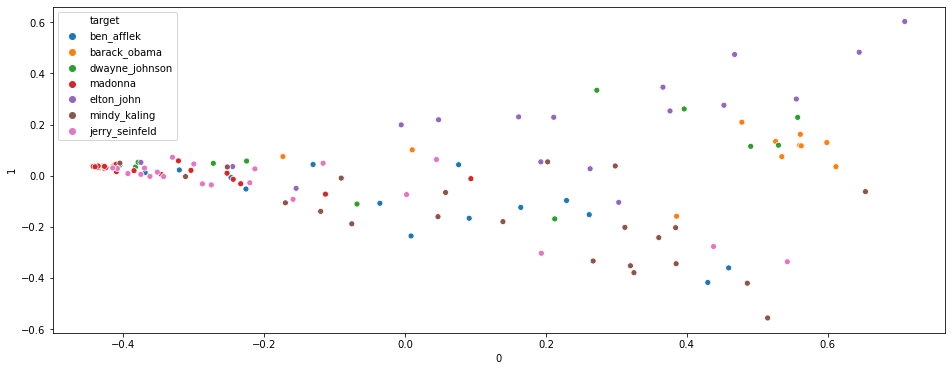

In [17]:
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# Create a PCA instance:
pca = PCA(n_components=2) 
# Fit pca to 'X'
pca_features = pca.fit_transform(newTrainX)
print (pca_features.shape)

df_plot = pd.DataFrame(pca_features)
df_plot["target"] = trainy

plt.figure(figsize=(16, 6))
sns.scatterplot(x=df_plot[0] , y= df_plot[1], data = df_plot,  hue = "target" )

## Clustering for the model_dropout_02

In [18]:
from keras.models import load_model
model2 = load_model("model_dropout_02.h5")
print('Loaded Model')
print(model2.inputs)
print(model2.outputs)

Loaded Model
[<KerasTensor: shape=(None, 200, 200, 3) dtype=float32 (created by layer 'input_2')>]
[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'sequential_1')>]


In [19]:
# convert each face in the train set to an embedding
newTrainX2 = list()
for face_pixels in trainX:
    embedding = get_embedding(model2, face_pixels)
    newTrainX2.append(embedding)
newTrainX2 = np.asarray(newTrainX2)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX2 = list()
for face_pixels in testX:
    embedding = get_embedding(model2, face_pixels)
    newTestX2.append(embedding)
newTestX2 = np.asarray(newTestX2)
print(newTestX2.shape)

(123, 7)
(35, 7)


In [22]:
import pandas as pd
df = pd.DataFrame(newTrainX2)
df["target"] = trainy
df.head()

,0,1,2,3,4,5,6,target
0,0.034147,0.016232,0.000076,0.000696,0.087020,0.860403,0.001425,ben_afflek
1,0.311605,0.086390,0.014921,0.009515,0.004429,0.561543,0.011597,ben_afflek
2,0.005525,0.007236,0.001337,0.000868,0.249276,0.234590,0.501169,ben_afflek
3,0.001237,0.290750,0.000375,0.001113,0.069116,0.624877,0.012533,ben_afflek
4,0.002955,0.061294,0.000953,0.003233,0.170289,0.522694,0.238582,ben_afflek


(123, 2)


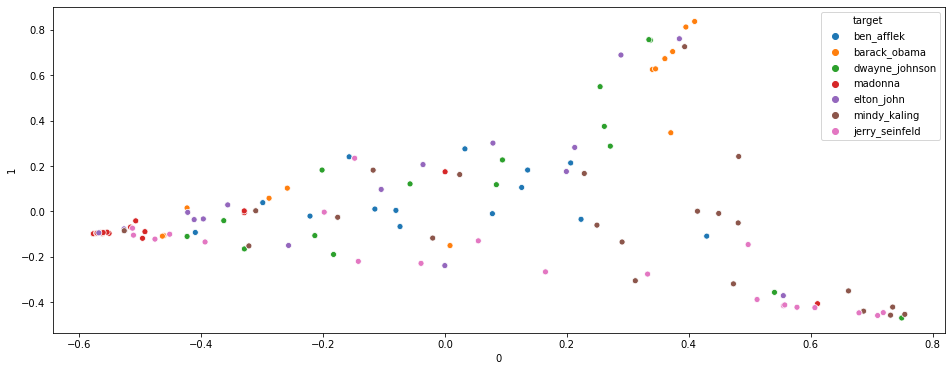

In [23]:
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# Create a PCA instance:
pca2 = PCA(n_components=2) 
# Fit pca to 'X'
pca_features2 = pca2.fit_transform(newTrainX2)
print (pca_features2.shape)

df_plot = pd.DataFrame(pca_features2)
df_plot["target"] = trainy

plt.figure(figsize=(16, 6))
sns.scatterplot(x=df_plot[0] , y= df_plot[1], data = df_plot,  hue = "target" )